In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot as plt
import copy
import glob
import sklearn
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import sys
# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation
sys.path.append('../utils')

# importing
from emg_data_loading import *

# Trying to classify fatigue

In [112]:
os.getcwd()

'/Users/htr365/no_icloud/quantified_self_all/quantified_self/data_processing/ml_pipeline'

In [153]:
X_vars = [ 'VAR_EMG', 'RMS_EMG', 'IEMG_EMG', 'MAV_EMG', 'LOG_EMG', 'WL_EMG', 'ACC_EMG',
       'DASDV_EMG', 'WAMP_EMG', 'MYOP_EMG', 'FR_EMG', 'MNP_EMG', 'TP_EMG', 'MNF_EMG', 'MDF_EMG',  'WENT_EMG',
           'VAR_MMG', 'RMS_MMG', 'IEMG_MMG', 'MAV_MMG', 'LOG_MMG', 'WL_MMG', 'ACC_MMG',
       'DASDV_MMG', 'WAMP_MMG', 'MYOP_MMG', 'FR_MMG', 'MNP_MMG', 'TP_MMG', 'MNF_MMG', 'MDF_MMG',  'WENT_MMG','muscle_contraction_2', 'muscle_contraction_3', 'prep_wallsit',
       'rest_1', 'rest_2', 'sit_down', 'sit_relaxed_1', 'sit_relaxed_2',
       'wallsit','AM']

outcome = ['cis_subjective_fatigue_lead1']

In [154]:
emg_path ='../../../data/data_features/'
survey_file = '../../../data/survey_data/pre_processed_survey_features.csv'
survey = pd.read_csv(survey_file)
identifiers  = pd.concat([get_dates('Amanda', survey, emg_path)])

In [156]:
indicators_train, indicators_val, indicators_test = identifiers[pd.to_datetime(identifiers['date'])<pd.to_datetime('2024-08-03')],\
    identifiers[(pd.to_datetime(identifiers['date'])<pd.to_datetime('2024-08-07'))*(pd.to_datetime(identifiers['date'])>=pd.to_datetime('2024-08-03'))],\
    identifiers[pd.to_datetime(identifiers['date'])>=pd.to_datetime('2024-08-07')]

In [158]:
data_train = data_loader(indicators_train,survey,emg_path,  outcome=outcome[0])
data_val = data_loader(indicators_val,survey,emg_path,  outcome=outcome[0])
data_test = data_loader(indicators_test,survey,emg_path,  outcome=outcome[0])

In [162]:
# get X and y for both train and test set

data_train = data_train.dropna(subset=X_vars+outcome)
data_test = data_test.dropna(subset=X_vars+outcome)
data_val = data_val.dropna(subset=X_vars+outcome)

X_train, X_val, X_test = np.array(data_train[X_vars]), np.array(data_val[X_vars]), np.array(data_test[X_vars])
y_train, y_val, y_test = np.array(data_train[outcome]).flatten(), np.array(data_val[outcome]).flatten(), np.array(data_test[outcome]).flatten()

In [164]:
n_features = 42

In [166]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)



In [168]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
        nn.Linear(n_features, 24),
        nn.ReLU(),
        nn.Linear(24, 12),
        nn.ReLU(),
        nn.Linear(12, 6),
        nn.ReLU(),
        nn.Linear(6, 1),
        nn.Sigmoid()
    )
    def forward(self, x):
        out = self.network(x)
        out = out*6+1
        return out
model  = ConvNet()

0
tensor(1.6857, grad_fn=<MeanBackward0>)
1
tensor(1.8199, grad_fn=<MeanBackward0>)
2
tensor(1.9439, grad_fn=<MeanBackward0>)
3
tensor(2.0468, grad_fn=<MeanBackward0>)
4
tensor(2.1439, grad_fn=<MeanBackward0>)
5
tensor(2.2348, grad_fn=<MeanBackward0>)
6
tensor(2.3245, grad_fn=<MeanBackward0>)
7
tensor(2.4126, grad_fn=<MeanBackward0>)
8
tensor(2.4893, grad_fn=<MeanBackward0>)
9
tensor(2.5553, grad_fn=<MeanBackward0>)
10
tensor(2.6025, grad_fn=<MeanBackward0>)
11
tensor(2.6535, grad_fn=<MeanBackward0>)
12
tensor(2.6630, grad_fn=<MeanBackward0>)
13
tensor(2.6725, grad_fn=<MeanBackward0>)
14
tensor(2.6820, grad_fn=<MeanBackward0>)
15
tensor(2.6915, grad_fn=<MeanBackward0>)
16
tensor(2.7009, grad_fn=<MeanBackward0>)
17
tensor(2.7103, grad_fn=<MeanBackward0>)
18
tensor(2.7197, grad_fn=<MeanBackward0>)
19
tensor(2.7290, grad_fn=<MeanBackward0>)
20
tensor(2.7384, grad_fn=<MeanBackward0>)
21
tensor(2.7477, grad_fn=<MeanBackward0>)
22
tensor(2.7569, grad_fn=<MeanBackward0>)
23
tensor(2.7639, gra

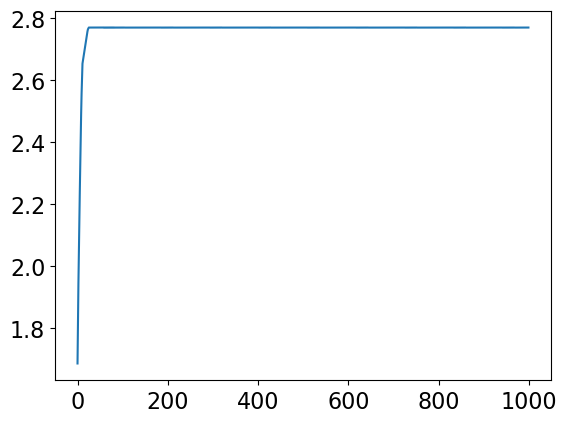

In [169]:

# loss function and optimizer
loss_fn = nn.L1Loss()  # mean absolute
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 1000   # number of epochs to run
batch_size = 50  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mae= np.inf   # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        print(epoch)
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            #X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # forward pass
            y_pred = model(X_batch)
            #print(np.abs(y_pred.detach().numpy()-y_batch.detach().numpy()))
            #print('finished calling model')
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mae=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    #X_val, y_val = X_val.to(device), y_val.to(device)
    y_pred = model(X_val)
    mae = loss_fn(y_pred, y_val)
    print(mae)
    mae = float(mae)
    history.append(mae)
    if mae < best_mae:
        best_mae = mae
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MAE: %.2f" % best_mae)
plt.plot(history)
plt.show()


In [170]:
outcome

['cis_subjective_fatigue_lead1']

In [171]:
#X_test = X_test.to(device)
y_pred = model(X_test)

In [172]:
out = pd.concat([pd.Series(y_pred.detach().cpu().numpy().reshape(-1)).reset_index(),data_test[['date']+outcome].reset_index()],axis=1).rename(columns={0:'pred'})
out_daily = out.groupby('date').mean('pred')

In [173]:
out_daily

,index,pred,index,cis_subjective_fatigue_lead1
date,,,,
2024-08-07,14946.5,3.661755,607.500000,2.125
2024-08-08,8384.0,3.661832,606.500000,5.875
2024-08-09,7223.5,3.661786,606.755043,5.375
2024-08-10,13729.5,3.661771,608.500000,6.500
2024-08-12,10203.5,3.661659,605.752577,5.750
2024-08-13,9594.0,3.661818,578.955017,5.250


In [174]:
np.mean(np.abs(out_daily['pred']-np.array(out_daily[outcome]).reshape(-1)))

1.9963147242863972

In [175]:


torch.save(model.state_dict(), '/Users/htr365/no_icloud/quantified_self_all/quantified_self/data_processing/ml_pipeline/prediction/amanda_nn_fatigue.pth')
pd.DataFrame(history).to_csv('/Users/htr365/no_icloud/quantified_self_all/quantified_self/data_processing/ml_pipeline/prediction/amanda_nn_fatigue_history.csv')
pd.DataFrame(y_pred.detach().numpy()).to_csv('/Users/htr365/no_icloud/quantified_self_all/quantified_self/data_processing/ml_pipeline/prediction/amanda_nn_fatigue_prediction.csv')
out_daily.to_csv('/Users/htr365/no_icloud/quantified_self_all/quantified_self/data_processing/ml_pipeline/prediction/amanda_nn_fatigue_daily_prediction.csv')

## Analysis of feature importance

In [176]:
gs = GradientShap(model)
#X_test, X_train = X_test.to(device), X_train.to(device)
gs_attr_test = gs.attribute(X_test, X_train)

In [177]:
fa = FeatureAblation(model)
fa_attr_test = fa.attribute(X_test)

In [178]:
dl = DeepLift(model)
dl_attr_test = dl.attribute(X_test)


/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [179]:
dl_attr_test_sum = dl_attr_test.cpu().detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.cpu().detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.cpu().detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

In [32]:
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: X_vars[idx], x_axis_data))

In [150]:
explainability = pd.concat([pd.Series(x_axis_data_labels),pd.Series(fa_attr_test_norm_sum),pd.Series(dl_attr_test_norm_sum),pd.Series(gs_attr_test_norm_sum)],axis=1).\
rename(columns={0:'Variable', 1:'Feature Ablation', 2: 'Deep Lift',3:'Gradient Shape'})

In [180]:
explainability.to_csv('/Users/htr365/no_icloud/quantified_self_all/quantified_self/data_processing/ml_pipeline/prediction/amanda_nn_fatigue_explainability.csv')

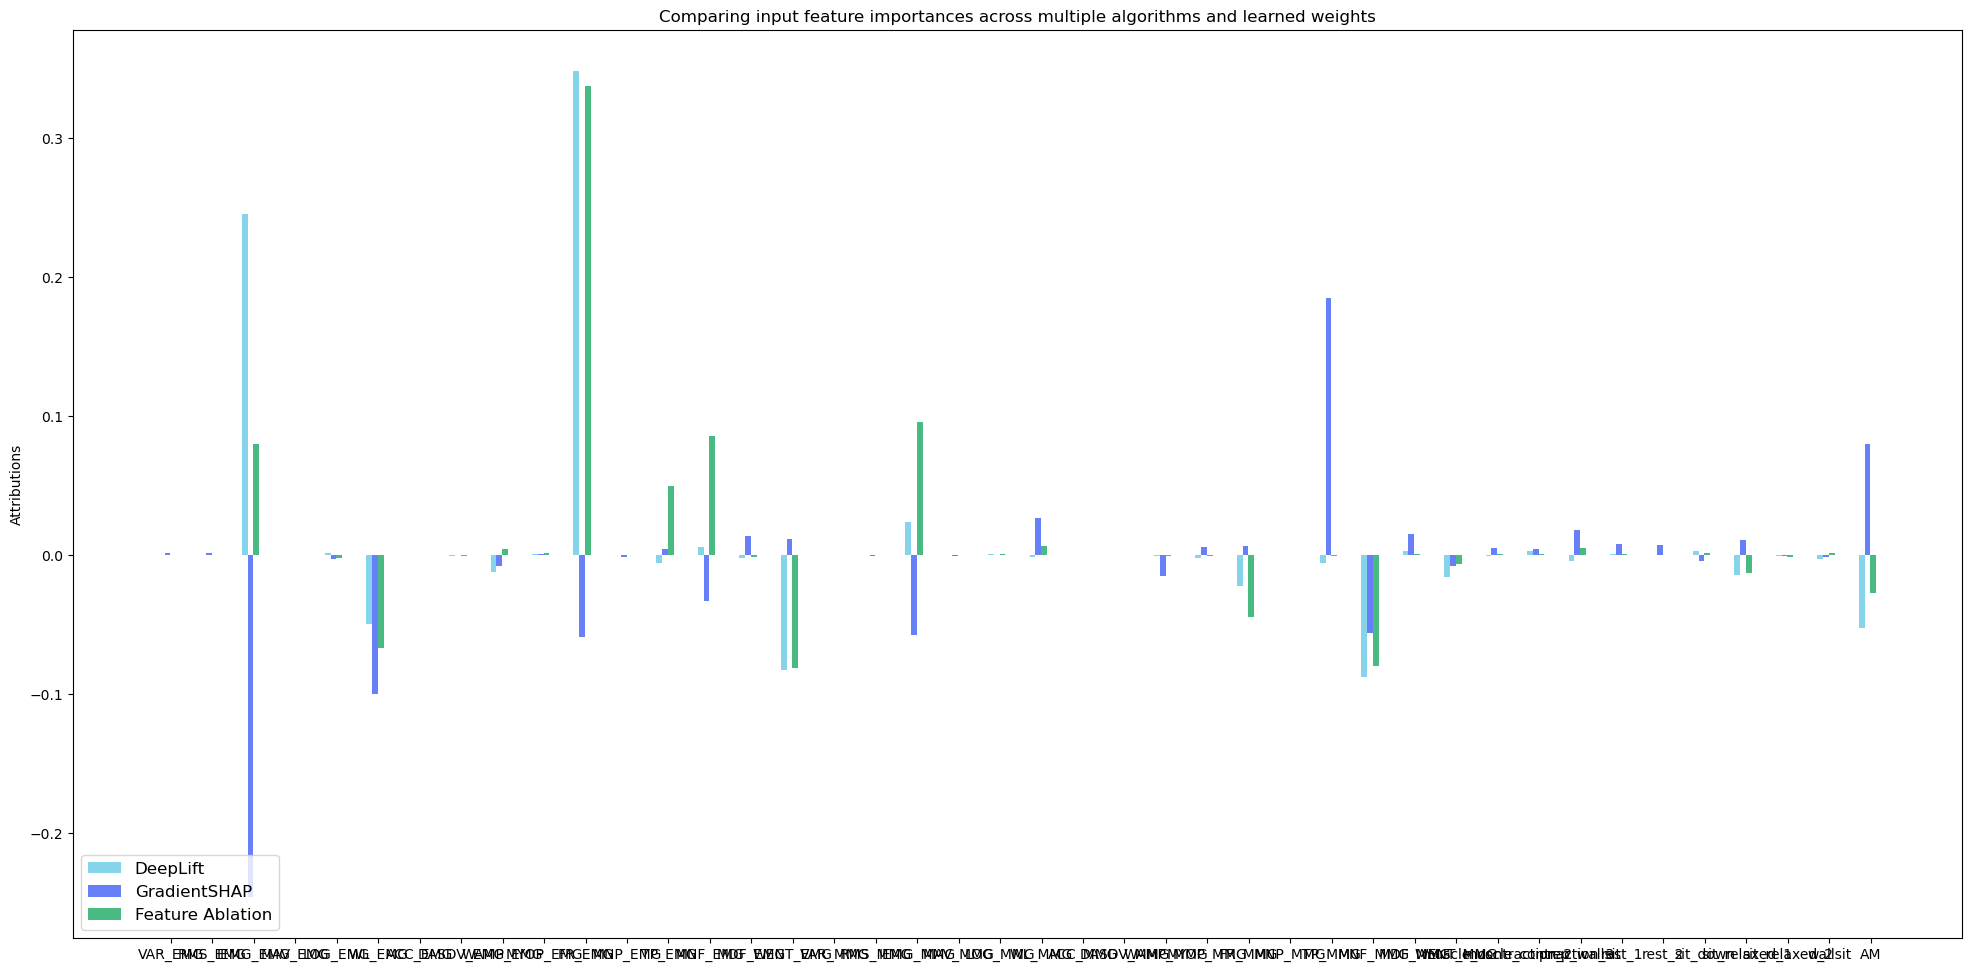

In [35]:
width = 0.14
legends = ['DeepLift', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))



#lin_weight = model[0].weight[0].numpy()
#y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

#ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
#ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

# OLD STUFF - 1D Convolution

In [ ]:
# def turn_to_3d(data, X_vars, outcome,max_size): 
#     data = data.dropna(subset=X_vars+outcome)  
#     grouped = data[X_vars+['date']].groupby('date')

#     arrays = []
#     for name, group in grouped:
#         # Convert the group to a 2D array
#         array_2d = group.drop(columns='date').values
        
#         # Determine the number of rows to add
#         num_rows_to_add = max_size - len(group)
        
#         if num_rows_to_add > 0:
#             # Create a padding array filled with NaNs
#             padding = np.full((num_rows_to_add, array_2d.shape[1]), np.float32(0))
            
#             # Concatenate the group array with the padding array
#             array_2d = np.vstack([array_2d, padding])
        
#         # Add to the list of arrays
#         arrays.append(array_2d)

#     # Stack into a 3D array
#     return [np.stack(arrays, axis=0), np.array(data.groupby('date')[outcome].first())]

In [ ]:

# grouped = data_train[X_vars+['date']].groupby('date')
# max_size = max(grouped.size())
# X_train, y_train = turn_to_3d(data_train, X_vars, outcome,max_size)
# X_val, y_val = turn_to_3d(data_val, X_vars, outcome,max_size)
# X_test, y_test = turn_to_3d(data_test, X_vars, outcome,max_size)

In [ ]:
# X_train = X_train.transpose(0,2, 1)
# X_val = X_val.transpose(0,2, 1)
# X_test = X_test.transpose(0,2, 1)

In [ ]:
class ConvNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(n_features, 64, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(10),
            nn.BatchNorm1d(64))
        self.layer2 = nn.Flatten()
        self.layer3 = nn.Sequential(
            nn.Linear(15488,100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,6),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Linear(6,1)
        )


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)

        return out

model = ConvNet1D()

In [ ]:
#out_1d = pd.concat([pd.Series(y_pred.detach().cpu().numpy().reshape(-1)).reset_index(),data_test.groupby('date').first()[outcome].reset_index()],axis=1)
#np.mean(np.abs(out_1d[outcome].values.reshape(-1)-out_1d[0].values))